# BA820 - Milestone 2: Color Substitution and Exclusion Rules

**Student:** Adam Schuler  
**Section:** A1 - Team A1  
**Date:** February 9, 2026

---

## Problem Statement: What Changed and Why

**Original question from M1:** The negative correlation between Burnt Umber and Dark Sienna/Midnight Black suggests they might be substitutes. What association rules can we find about which colors are never used together?

**What changed based on M1 feedback:** We were asked to incorporate text features and explore season relationships. For my question that means checking whether the substitution rules hold across different seasons, and whether painting themes (from title keywords) have their own color rules.

## 1. Setup and Data Loading

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Load the Bob Ross dataset
df = pd.read_csv('https://drive.google.com/uc?export=download&id=17d9X4zUbU4uPD_oEqb0hlnMexbjZcpeR')

color_cols = [c for c in df.columns if df[c].dtype == bool]
df.head()

,painting_index,img_src,painting_title,season,episode,num_colors,youtube_src,colors,color_hex,Black_Gesso,...,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson
0,282,https://www.twoinchbrush.com/images/painting28...,A Walk in the Woods,1,1,8,https://www.youtube.com/embed/oh5p5f5_-7A,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
1,283,https://www.twoinchbrush.com/images/painting28...,Mt. McKinley,1,2,8,https://www.youtube.com/embed/RInDWhYceLU,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
2,284,https://www.twoinchbrush.com/images/painting28...,Ebony Sunset,1,3,9,https://www.youtube.com/embed/UOziR7PoVco,"['Alizarin Crimson', 'Black Gesso', 'Bright Re...","['#4E1500', '#000000', '#DB0000', '#FFEC00', '...",True,...,False,False,False,True,True,True,True,True,False,True
3,285,https://www.twoinchbrush.com/images/painting28...,Winter Mist,1,4,3,https://www.youtube.com/embed/0pwoixRikn4,"['Prussian Blue', 'Titanium White', 'Van Dyke ...","['#021E44', '#FFFFFF', '#221B15']",False,...,False,False,False,False,True,False,True,True,False,False
4,286,https://www.twoinchbrush.com/images/painting28...,Quiet Stream,1,5,8,https://www.youtube.com/embed/DFSIQNjKRfk,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True


## 2. EDA

Before running any rules, I want to see how often each color gets used and which ones are correlated.

In [9]:
# Usage rates
color_usage = df[color_cols].sum().sort_values(ascending=False)
color_pct = (color_usage / len(df) * 100).round(1)

print("Color Usage:")
for color, pct in color_pct.items():
    print(f"- {color}: {pct}%")
print(f"Average colors per painting: {df['num_colors'].mean():.1f}")

Color Usage:
- Titanium_White: 99.3%
- Alizarin_Crimson: 94.3%
- Van_Dyke_Brown: 92.1%
- Cadmium_Yellow: 85.9%
- Yellow_Ochre: 81.1%
- Phthalo_Blue: 80.1%
- Bright_Red: 79.7%
- Midnight_Black: 78.7%
- Sap_Green: 75.9%
- Indian_Yellow: 72.5%
- Dark_Sienna: 72.0%
- Prussian_Blue: 65.3%
- Phthalo_Green: 28.8%
- Black_Gesso: 25.1%
- Burnt_Umber: 13.6%
- Liquid_Clear: 12.7%
- Liquid_Black: 3.5%
- Indian_Red: 0.2%
Average colors per painting: 10.6


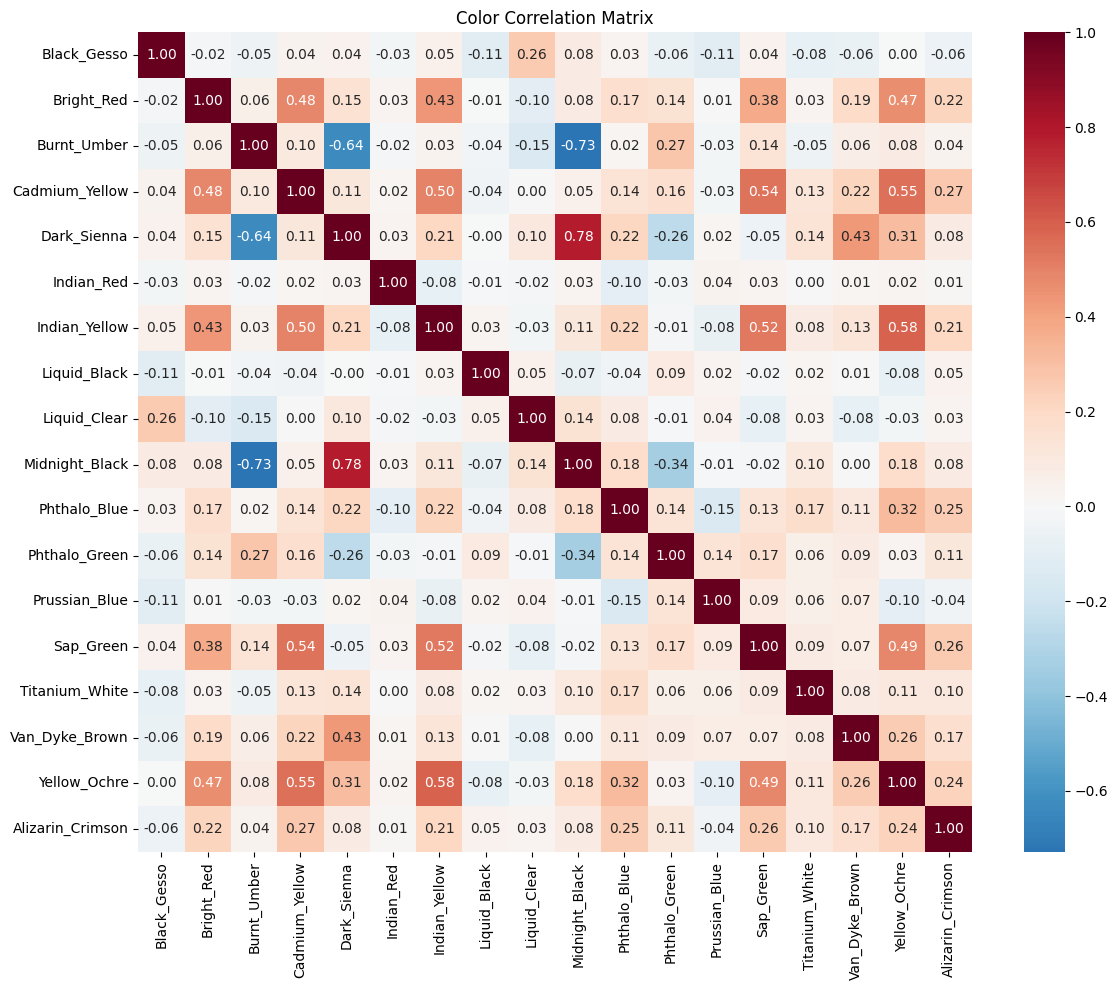

In [10]:
# Correlation heatmap - looking for negative correlations
color_corr = df[color_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(color_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0)
plt.title('Color Correlation Matrix')
plt.tight_layout()
plt.show()

Dark Sienna and Midnight Black have a strong positive correlation (~0.78), meaning they tend to show up in the same paintings. Burnt Umber is negatively correlated with both. That's what makes them the main substitution candidates. But correlation just tells us they're related, association rules can hopefully show us the actual patterns.

### 2.1 Feature Engineering: Theme Tags from Titles

Based on M1 feedback to incorporate text features. I pulled simple keyword tags from the painting titles.

In [11]:
df['title_lower'] = df['painting_title'].str.lower()

df['theme_winter'] = df['title_lower'].str.contains('winter|snow|frost|cold|ice', regex=True)
df['theme_mountain'] = df['title_lower'].str.contains('mountain|peak|summit|ridge', regex=True)
df['theme_water'] = df['title_lower'].str.contains('lake|river|stream|ocean|sea|waterfall|pond|creek|falls', regex=True)

theme_cols = ['theme_winter', 'theme_mountain', 'theme_water']
for col in theme_cols:
    print(f"  {col:<20s}  {df[col].sum()} paintings ({df[col].mean():.1%})")

  theme_winter          54 paintings (13.4%)
  theme_mountain        62 paintings (15.4%)
  theme_water           86 paintings (21.3%)


## 3. Analysis 1: Association Rule Mining

Association rule mining finds patterns in which items appear together and which ones don't. I'm using it here to identify which colors tend to co-occur in the same painting, and which ones seem to avoid each other, that's the substitution pattern I'm looking for.

### 3.1 Co-occurrence Rules

In [12]:
df_basket = df[color_cols].copy()

frequent_itemsets = apriori(df_basket, min_support=0.03, use_colnames=True)
frequent_itemsets.sort_values(by="support", ascending=False)

,support,itemsets
13,0.992556,(Titanium_White)
16,0.942928,(Alizarin_Crimson)
132,0.937965,"(Alizarin_Crimson, Titanium_White)"
14,0.920596,(Van_Dyke_Brown)
130,0.915633,"(Van_Dyke_Brown, Titanium_White)"
...,...,...
15147,0.032258,"(Van_Dyke_Brown, Prussian_Blue, Phthalo_Blue, ..."
15148,0.032258,"(Prussian_Blue, Phthalo_Blue, Liquid_Clear, Da..."
6314,0.032258,"(Van_Dyke_Brown, Prussian_Blue, Phthalo_Blue, ..."
5167,0.032258,"(Bright_Red, Alizarin_Crimson, Cadmium_Yellow,..."


In [13]:
# Association rules
rules = association_rules(
    frequent_itemsets,
    num_itemsets=frequent_itemsets.shape[0],
    metric="confidence", min_threshold=0.3
)
rules.sort_values(by=["support", "confidence"])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
4414,"(Black_Gesso, Prussian_Blue, Yellow_Ochre)",(Phthalo_Green),0.106700,0.287841,0.032258,0.302326,1.050321,1.0,0.001545,1.020761,0.053632,0.089041,0.020339,0.207197
14277,"(Liquid_Clear, Midnight_Black, Phthalo_Blue)",(Phthalo_Green),0.106700,0.287841,0.032258,0.302326,1.050321,1.0,0.001545,1.020761,0.053632,0.089041,0.020339,0.207197
22494,"(Dark_Sienna, Liquid_Clear)","(Black_Gesso, Indian_Yellow, Prussian_Blue)",0.106700,0.096774,0.032258,0.302326,3.124031,1.0,0.021932,1.294624,0.761111,0.188406,0.227575,0.317829
23113,"(Dark_Sienna, Liquid_Clear)","(Black_Gesso, Phthalo_Blue, Prussian_Blue)",0.106700,0.111663,0.032258,0.302326,2.707494,1.0,0.020344,1.273284,0.705983,0.173333,0.214629,0.295607
23205,"(Dark_Sienna, Liquid_Clear)","(Black_Gesso, Prussian_Blue, Sap_Green)",0.106700,0.114144,0.032258,0.302326,2.648635,1.0,0.020079,1.269727,0.696795,0.171053,0.212429,0.292467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,(Van_Dyke_Brown),(Alizarin_Crimson),0.920596,0.942928,0.878412,0.954178,1.011931,1.0,0.010357,1.245512,0.148482,0.891688,0.197117,0.942878
178,(Titanium_White),(Van_Dyke_Brown),0.992556,0.920596,0.915633,0.922500,1.002069,1.0,0.001890,1.024574,0.277326,0.917910,0.023984,0.958555
177,(Van_Dyke_Brown),(Titanium_White),0.920596,0.992556,0.915633,0.994609,1.002069,1.0,0.001890,1.380893,0.025999,0.917910,0.275831,0.958555
182,(Titanium_White),(Alizarin_Crimson),0.992556,0.942928,0.937965,0.945000,1.002197,1.0,0.002057,1.037672,0.294533,0.940299,0.036304,0.969868


In [14]:
# Filter for strong pairwise co-occurrence rules
rules_filtered = rules[
    (rules['confidence'] > 0.8) &
    (rules['lift'] > 1.0) &
    (rules['antecedents'].apply(len) == 1) &
    (rules['consequents'].apply(len) == 1)
]
rules_filtered.sort_values(by=["confidence", "lift"], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
112,(Liquid_Black),(Alizarin_Crimson),0.034739,0.942928,0.034739,1.000000,1.060526,1.0,0.001983,inf,0.059126,0.036842,1.000000,0.518421
84,(Dark_Sienna),(Titanium_White),0.719603,0.992556,0.719603,1.000000,1.007500,1.0,0.005357,inf,0.026549,0.725000,1.000000,0.862500
110,(Liquid_Black),(Titanium_White),0.034739,0.992556,0.034739,1.000000,1.007500,1.0,0.000259,inf,0.007712,0.035000,1.000000,0.517500
117,(Liquid_Clear),(Titanium_White),0.126551,0.992556,0.126551,1.000000,1.007500,1.0,0.000942,inf,0.008523,0.127500,1.000000,0.563750
143,(Phthalo_Blue),(Titanium_White),0.801489,0.992556,0.801489,1.000000,1.007500,1.0,0.005966,inf,0.037500,0.807500,1.000000,0.903750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,(Van_Dyke_Brown),(Phthalo_Blue),0.920596,0.801489,0.749380,0.814016,1.015630,1.0,0.011533,1.067357,0.193812,0.770408,0.063106,0.874500
22,(Midnight_Black),(Bright_Red),0.786600,0.796526,0.640199,0.813880,1.021787,1.0,0.013651,1.093241,0.099919,0.678947,0.085289,0.808809
11,(Black_Gesso),(Yellow_Ochre),0.250620,0.811414,0.203474,0.811881,1.000575,1.0,0.000117,1.002481,0.000767,0.236994,0.002475,0.531323
142,(Titanium_White),(Phthalo_Blue),0.992556,0.801489,0.801489,0.807500,1.007500,1.0,0.005966,1.031227,1.000000,0.807500,0.030281,0.903750


These are the colors that tend to appear together. But my question is about which colors *don't* appear together, so I need to look at rules where lift is below 1 instead of above it.

### 3.2 Exclusion Rules

When lift < 1, it means two colors show up together *less* often than you'd expect by random chance. That's the substitution signal I'm looking for.

In [15]:
# Filter for exclusion patterns: lift < 1 means colors co-occur LESS than expected
exclusion_rules = rules[
    (rules['lift'] < 1.0) &
    (rules['antecedents'].apply(len) == 1) &
    (rules['consequents'].apply(len) == 1)
].sort_values('lift')

print(f"Exclusion rules (lift < 1): {len(exclusion_rules)}")
display(exclusion_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(15))

Exclusion rules (lift < 1): 31


,antecedents,consequents,support,confidence,lift
123,(Phthalo_Green),(Midnight_Black),0.163772,0.568966,0.723322
79,(Phthalo_Green),(Dark_Sienna),0.153846,0.534483,0.742747
20,(Liquid_Clear),(Bright_Red),0.086849,0.686275,0.861585
7,(Black_Gesso),(Prussian_Blue),0.141439,0.564356,0.864774
116,(Liquid_Clear),(Sap_Green),0.084367,0.666667,0.877996
118,(Liquid_Clear),(Van_Dyke_Brown),0.109181,0.862745,0.937160
139,(Prussian_Blue),(Phthalo_Blue),0.493797,0.756654,0.944061
138,(Phthalo_Blue),(Prussian_Blue),0.493797,0.616099,0.944061
92,(Liquid_Clear),(Indian_Yellow),0.086849,0.686275,0.947153
43,(Burnt_Umber),(Prussian_Blue),0.084367,0.618182,0.947252


The top exclusion pairs are actually Phthalo Green with Midnight Black (lift 0.72) and Dark Sienna (lift 0.74), not Burnt Umber and Dark Sienna like I expected. Burnt Umber only shows up in 13.6% of paintings overall, so it doesn't generate strong pairwise stats. The seasonal analysis below ends up being better evidence for the Burnt Umber / Dark Sienna substitution.

### 3.3 Temporal Analysis: Do the Rules Change Across Seasons?

I wanted to check if the reason Burnt Umber and Dark Sienna avoid each other is just because Ross changed his palette at some point during the show. If that's the case, the exclusion should go away when you only look at one era.

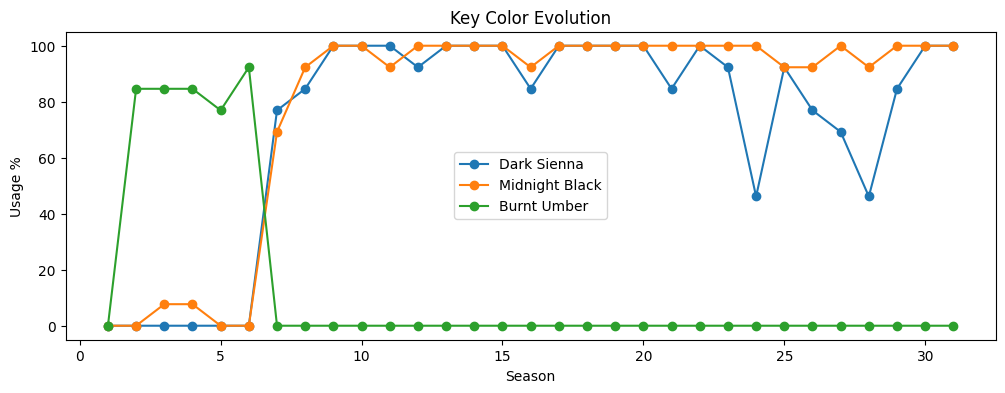

In [16]:
sub_colors = ['Dark_Sienna', 'Midnight_Black', 'Burnt_Umber']

plt.figure(figsize=(12, 4))
for color in sub_colors:
    usage = df.groupby('season')[color].mean() * 100
    plt.plot(usage.index, usage.values, marker='o', label=color.replace('_', ' '))

plt.xlabel('Season')
plt.ylabel('Usage %')
plt.title('Key Color Evolution')
plt.legend()
plt.show()

This is pretty clear. Burnt Umber is around 85% in the first few seasons, then drops to zero around season 7. Dark Sienna and Midnight Black jump up at the same time. It's not a slow fade, it's basically a one-season switch.

In [17]:
# Check co-occurrence in early vs late eras
early_df = df[df['season'] <= 10]
late_df = df[df['season'] >= 21]

print(f"Early (S1-10): {len(early_df)} paintings    Late (S21-31): {len(late_df)} paintings")
print(f"\n{'Color':<20s} {'Early':>8s} {'Late':>8s}")
print("-" * 40)
for c in sub_colors:
    print(f"  {c:<20s} {early_df[c].mean():>6.1%}   {late_df[c].mean():>6.1%}")

Early (S1-10): 130 paintings    Late (S21-31): 143 paintings

Color                   Early     Late
----------------------------------------
  Dark_Sienna           36.2%    81.1%
  Midnight_Black        37.7%    97.9%
  Burnt_Umber           42.3%     0.0%


In [18]:
# Run rules on early era only
early_basket = early_df[color_cols].copy()
freq_early = apriori(early_basket, min_support=0.02, use_colnames=True)
rules_early = association_rules(freq_early, num_itemsets=freq_early.shape[0], metric="confidence", min_threshold=0.3)

# Filter for exclusion rules
early_exclusion = rules_early[
    (rules_early['lift'] < 1.0) &
    (rules_early['antecedents'].apply(len) == 1) &
    (rules_early['consequents'].apply(len) == 1)
].sort_values('lift')

print(f"Exclusion rules in EARLY seasons (lift < 1): {len(early_exclusion)}")
display(early_exclusion[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

Exclusion rules in EARLY seasons (lift < 1): 53


,antecedents,consequents,support,confidence,lift
66,(Liquid_Black),(Cadmium_Yellow),0.023077,0.600000,0.690265
22,(Liquid_Black),(Bright_Red),0.023077,0.600000,0.702703
93,(Dark_Sienna),(Prussian_Blue),0.153846,0.425532,0.737589
135,(Midnight_Black),(Prussian_Blue),0.161538,0.428571,0.742857
9,(Black_Gesso),(Sap_Green),0.092308,0.571429,0.765832
130,(Liquid_Clear),(Van_Dyke_Brown),0.023077,0.750000,0.792683
124,(Liquid_Black),(Van_Dyke_Brown),0.030769,0.800000,0.845528
94,(Dark_Sienna),(Sap_Green),0.230769,0.638298,0.855451
95,(Sap_Green),(Dark_Sienna),0.230769,0.309278,0.855451
4,(Black_Gesso),(Indian_Yellow),0.092308,0.571429,0.863787


In [19]:
# Same for late era
late_basket = late_df[color_cols].copy()
freq_late = apriori(late_basket, min_support=0.02, use_colnames=True)
rules_late = association_rules(freq_late, num_itemsets=freq_late.shape[0], metric="confidence", min_threshold=0.3)

late_exclusion = rules_late[
    (rules_late['lift'] < 1.0) &
    (rules_late['antecedents'].apply(len) == 1) &
    (rules_late['consequents'].apply(len) == 1)
].sort_values('lift')

print(f"Exclusion rules in LATE seasons (lift < 1): {len(late_exclusion)}")
display(late_exclusion[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

Exclusion rules in LATE seasons (lift < 1): 52


,antecedents,consequents,support,confidence,lift
15,(Black_Gesso),(Prussian_Blue),0.216783,0.659574,0.881487
33,(Liquid_Clear),(Bright_Red),0.153846,0.666667,0.907937
128,(Liquid_Clear),(Prussian_Blue),0.160839,0.696970,0.931464
132,(Liquid_Clear),(Yellow_Ochre),0.174825,0.757576,0.942029
5,(Dark_Sienna),(Black_Gesso),0.251748,0.310345,0.944241
4,(Black_Gesso),(Dark_Sienna),0.251748,0.765957,0.944241
20,(Van_Dyke_Brown),(Black_Gesso),0.258741,0.310924,0.946004
21,(Black_Gesso),(Van_Dyke_Brown),0.258741,0.787234,0.946004
176,(Yellow_Ochre),(Prussian_Blue),0.573427,0.713043,0.952946
175,(Prussian_Blue),(Yellow_Ochre),0.573427,0.766355,0.952946


When I run rules within just one era, the Burnt Umber / Dark Sienna exclusion doesn't come up. That's because within each era, one of them dominates and the other is barely there. The top exclusion rules shift to other pairs like Liquid Black and Black Gesso/Prussian Blue.

### 3.4 Theme-Based Analysis: Winter Paintings

Do winter-themed paintings use different color combinations?

In [20]:
# Color usage differences in winter vs non-winter
winter = df[df['theme_winter']][color_cols].mean()
not_winter = df[~df['theme_winter']][color_cols].mean()

print("Biggest differences in winter paintings:")
for color in color_cols:
    diff = winter[color] - not_winter[color]
    if abs(diff) > 0.10:
        print(f"  {color:<20s}  winter: {winter[color]:.0%}  other: {not_winter[color]:.0%}")

Biggest differences in winter paintings:
  Black_Gesso           winter: 11%  other: 27%
  Bright_Red            winter: 44%  other: 85%
  Cadmium_Yellow        winter: 39%  other: 93%
  Dark_Sienna           winter: 63%  other: 73%
  Indian_Yellow         winter: 28%  other: 79%
  Phthalo_Green         winter: 9%  other: 32%
  Sap_Green             winter: 20%  other: 85%
  Van_Dyke_Brown        winter: 80%  other: 94%
  Yellow_Ochre          winter: 39%  other: 88%


Winter paintings drop most of the warm colors pretty significantly - Sap Green goes from 85% down to 20%, Cadmium Yellow from 93% to 39%. Makes sense.

In [21]:
# Run co-occurrence rules on winter subset
winter_basket = df[df['theme_winter']][color_cols].copy()
print(f"Winter paintings: {len(winter_basket)}")

freq_winter = apriori(winter_basket, min_support=0.05, use_colnames=True)
rules_winter = association_rules(
    freq_winter,
    num_itemsets=freq_winter.shape[0],
    metric="confidence", min_threshold=0.5
)

rules_winter_filtered = rules_winter[
    (rules_winter['confidence'] > 0.8) &
    (rules_winter['lift'] > 1.0) &
    (rules_winter['antecedents'].apply(len) == 1) &
    (rules_winter['consequents'].apply(len) == 1)
].sort_values("lift", ascending=False)

print(f"\nStrong co-occurrence rules for winter paintings:")
for _, row in rules_winter_filtered.head(10).iterrows():
    ant = list(row['antecedents'])[0]
    con = list(row['consequents'])[0]
    print(f"  {ant:<20s} -> {con:<20s}  conf: {row['confidence']:.3f}  lift: {row['lift']:.3f}")

Winter paintings: 54

Strong co-occurrence rules for winter paintings:
  Phthalo_Green        -> Cadmium_Yellow        conf: 1.000  lift: 2.571
  Phthalo_Green        -> Bright_Red            conf: 0.800  lift: 1.800
  Black_Gesso          -> Prussian_Blue         conf: 1.000  lift: 1.459
  Liquid_Clear         -> Prussian_Blue         conf: 1.000  lift: 1.459
  Yellow_Ochre         -> Dark_Sienna           conf: 0.857  lift: 1.361
  Phthalo_Green        -> Van_Dyke_Brown        conf: 1.000  lift: 1.256
  Indian_Yellow        -> Phthalo_Blue          conf: 0.933  lift: 1.229
  Liquid_Clear         -> Midnight_Black        conf: 1.000  lift: 1.227
  Dark_Sienna          -> Van_Dyke_Brown        conf: 0.971  lift: 1.219
  Yellow_Ochre         -> Van_Dyke_Brown        conf: 0.952  lift: 1.196


It seems that nearly every winter painting that used Phthalo Green also used Cadmium Yellow (lift 2.57). Interesting pairing but only 54 paintings in the subset, so I wouldn't over rely on these.

## 4. Analysis 2: K-Means Clustering of Color Palettes

Association rules look at pairs of colors. Clustering is a different approach, it groups paintings by their entire color profile and sees if natural groupings emerge.

In [22]:
from sklearn.preprocessing import StandardScaler

# Only keep numeric values
df_numeric = df[color_cols].copy().astype(int)

# Normalize
sc = StandardScaler()
df_normalized = pd.DataFrame(sc.fit_transform(df_numeric), columns=df_numeric.columns)
df_normalized.index = df_numeric.index

display(df_normalized)

,Black_Gesso,Bright_Red,Burnt_Umber,Cadmium_Yellow,Dark_Sienna,Indian_Red,Indian_Yellow,Liquid_Black,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson
0,-0.578305,0.505422,-0.39755,0.405882,-1.601990,-0.049875,-1.621922,-0.189710,-0.380639,-1.919908,-2.009353,1.572939,0.729602,0.563022,0.086603,0.293689,-2.074279,0.246021
1,-0.578305,0.505422,-0.39755,0.405882,-1.601990,-0.049875,-1.621922,-0.189710,-0.380639,-1.919908,-2.009353,1.572939,0.729602,0.563022,0.086603,0.293689,-2.074279,0.246021
2,1.729190,0.505422,-0.39755,0.405882,-1.601990,-0.049875,-1.621922,-0.189710,-0.380639,-1.919908,-2.009353,1.572939,0.729602,0.563022,0.086603,0.293689,-2.074279,0.246021
3,-0.578305,-1.978543,-0.39755,-2.463773,-1.601990,-0.049875,-1.621922,-0.189710,-0.380639,-1.919908,-2.009353,-0.635752,0.729602,-1.776130,0.086603,0.293689,-2.074279,-4.064694
4,-0.578305,0.505422,-0.39755,0.405882,-1.601990,-0.049875,-1.621922,-0.189710,-0.380639,-1.919908,-2.009353,1.572939,0.729602,0.563022,0.086603,0.293689,-2.074279,0.246021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,-0.578305,0.505422,-0.39755,0.405882,0.624224,-0.049875,0.616553,5.271216,-0.380639,0.520858,0.497673,1.572939,0.729602,0.563022,0.086603,0.293689,0.482095,0.246021
399,1.729190,0.505422,-0.39755,0.405882,0.624224,-0.049875,0.616553,-0.189710,2.627158,0.520858,0.497673,1.572939,-1.370610,-1.776130,0.086603,0.293689,0.482095,0.246021
400,-0.578305,0.505422,-0.39755,0.405882,0.624224,-0.049875,0.616553,-0.189710,-0.380639,0.520858,0.497673,-0.635752,0.729602,0.563022,0.086603,0.293689,0.482095,0.246021
401,-0.578305,-1.978543,-0.39755,-2.463773,0.624224,-0.049875,-1.621922,-0.189710,-0.380639,0.520858,0.497673,-0.635752,0.729602,-1.776130,0.086603,0.293689,-2.074279,0.246021


In [23]:
df_normalized.describe()

,Black_Gesso,Bright_Red,Burnt_Umber,Cadmium_Yellow,Dark_Sienna,Indian_Red,Indian_Yellow,Liquid_Black,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson
count,4.030000e+02,4.030000e+02,4.030000e+02,4.030000e+02,4.030000e+02,4.030000e+02,4.030000e+02,4.030000e+02,4.030000e+02,4.030000e+02,4.030000e+02,4.030000e+02,4.030000e+02,4.030000e+02,4.030000e+02,4.030000e+02,4.030000e+02,4.030000e+02
mean,-3.526267e-17,9.697233e-17,-7.052533e-17,-8.815667e-18,-1.763133e-17,-8.815667e-18,4.848617e-17,-2.203917e-18,5.289400e-17,1.057880e-16,3.967050e-17,-5.289400e-17,-1.057880e-16,1.586820e-16,-4.738421e-16,-7.052533e-17,-5.289400e-17,8.815667e-18
std,1.001243e+00,1.001243e+00,1.001243e+00,1.001243e+00,1.001243e+00,1.001243e+00,1.001243e+00,1.001243e+00,1.001243e+00,1.001243e+00,1.001243e+00,1.001243e+00,1.001243e+00,1.001243e+00,1.001243e+00,1.001243e+00,1.001243e+00,1.001243e+00
min,-5.783054e-01,-1.978543e+00,-3.975500e-01,-2.463773e+00,-1.601990e+00,-4.987547e-02,-1.621922e+00,-1.897096e-01,-3.806394e-01,-1.919908e+00,-2.009353e+00,-6.357525e-01,-1.370610e+00,-1.776130e+00,-1.154701e+01,-3.404960e+00,-2.074279e+00,-4.064694e+00
25%,-5.783054e-01,5.054223e-01,-3.975500e-01,4.058816e-01,-1.601990e+00,-4.987547e-02,-1.621922e+00,-1.897096e-01,-3.806394e-01,5.208583e-01,4.976726e-01,-6.357525e-01,-1.370610e+00,5.630217e-01,8.660254e-02,2.936892e-01,4.820953e-01,2.460210e-01
50%,-5.783054e-01,5.054223e-01,-3.975500e-01,4.058816e-01,6.242237e-01,-4.987547e-02,6.165525e-01,-1.897096e-01,-3.806394e-01,5.208583e-01,4.976726e-01,-6.357525e-01,7.296022e-01,5.630217e-01,8.660254e-02,2.936892e-01,4.820953e-01,2.460210e-01
75%,5.754425e-01,5.054223e-01,-3.975500e-01,4.058816e-01,6.242237e-01,-4.987547e-02,6.165525e-01,-1.897096e-01,-3.806394e-01,5.208583e-01,4.976726e-01,1.572939e+00,7.296022e-01,5.630217e-01,8.660254e-02,2.936892e-01,4.820953e-01,2.460210e-01
max,1.729190e+00,5.054223e-01,2.515407e+00,4.058816e-01,6.242237e-01,2.004994e+01,6.165525e-01,5.271216e+00,2.627158e+00,5.208583e-01,4.976726e-01,1.572939e+00,7.296022e-01,5.630217e-01,8.660254e-02,2.936892e-01,4.820953e-01,2.460210e-01


### 4.1 Choosing k

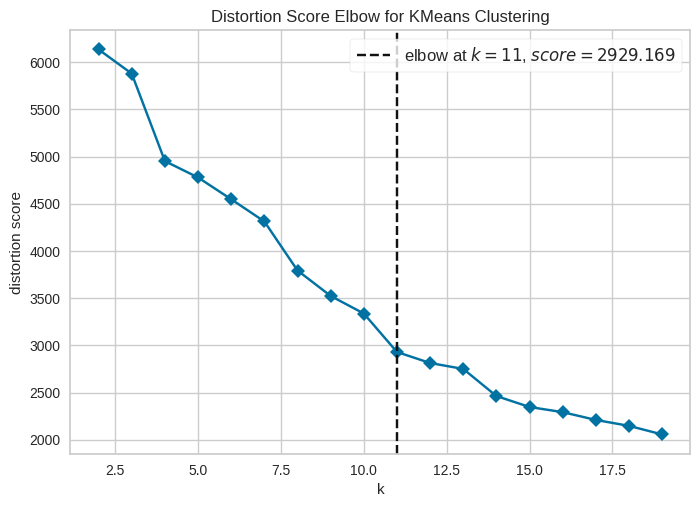

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

clustering = KMeans(random_state=42)
visualizer = KElbowVisualizer(
    clustering, k=(2, 20), metric='distortion', timings=False
)

visualizer.fit(df_normalized)
visualizer.show()

No clear elbow. The algorithm picked k=11 but that's way too many groups for 403 paintings. I went with k=5 to keep it interpretable and checked it with the silhouette plot.

In [25]:
n_clusters_kmeans = 5

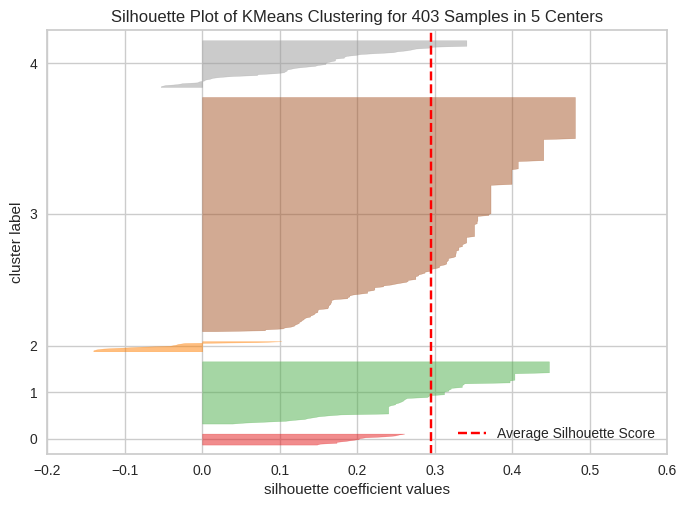

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 403 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [26]:
from yellowbrick.cluster import SilhouetteVisualizer

kmeans_model = KMeans(n_clusters_kmeans, random_state=42)
visualizer = SilhouetteVisualizer(kmeans_model, timings=False)

visualizer.fit(df_normalized)
visualizer.show()

### 4.2 Cluster Profiles

In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=42)

# Fit the model and predict
df_normalized['cluster_labels'] = kmeans.fit_predict(df_normalized).astype(str)

df_normalized['cluster_labels'].value_counts()

,count
cluster_labels,
3,257
1,69
4,52
0,13
2,12


In [28]:
# Cluster centers back in original scale
cluster_profiles = pd.DataFrame(
    sc.inverse_transform(df_normalized.groupby('cluster_labels').median(numeric_only=True)),
    columns=df_normalized.columns[:-1]
)
cluster_profiles.index = [f'Cluster {i}' for i in range(n_clusters_kmeans)]

print("Cluster median values for substitution colors (original scale):")
display(cluster_profiles[sub_colors])

Cluster median values for substitution colors (original scale):


,Dark_Sienna,Midnight_Black,Burnt_Umber
Cluster 0,1.0,1.0,0.0
Cluster 1,0.0,0.0,1.0
Cluster 2,0.0,0.0,0.0
Cluster 3,1.0,1.0,0.0
Cluster 4,1.0,1.0,0.0


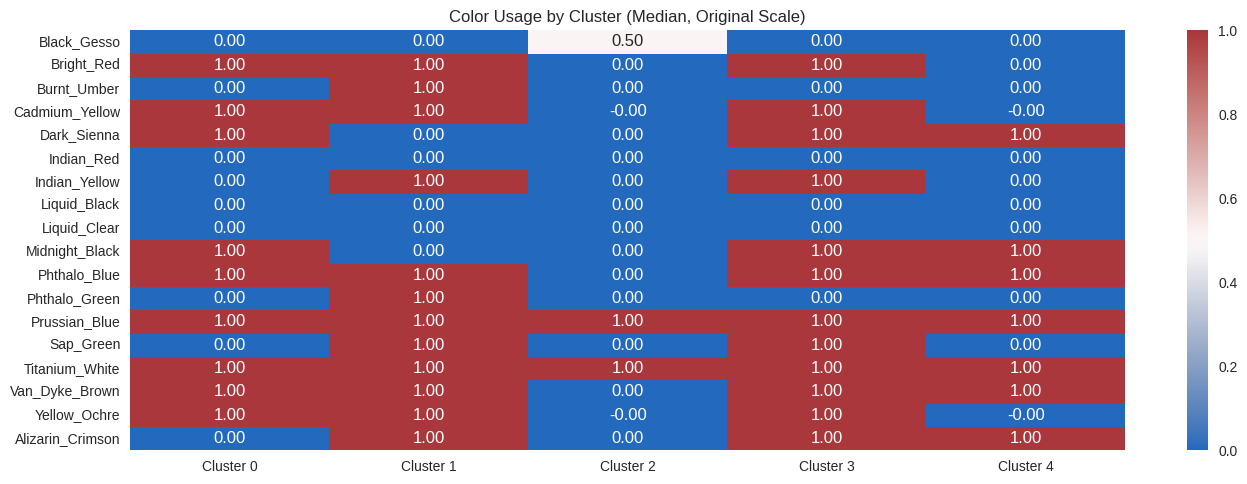

In [29]:
# Heatmap of color usage by cluster
plt.figure(figsize=(14, 5))
sns.heatmap(cluster_profiles.T, annot=True, fmt='.2f', cmap='vlag', center=0.5)
plt.title('Color Usage by Cluster (Median, Original Scale)')
plt.tight_layout()
plt.show()

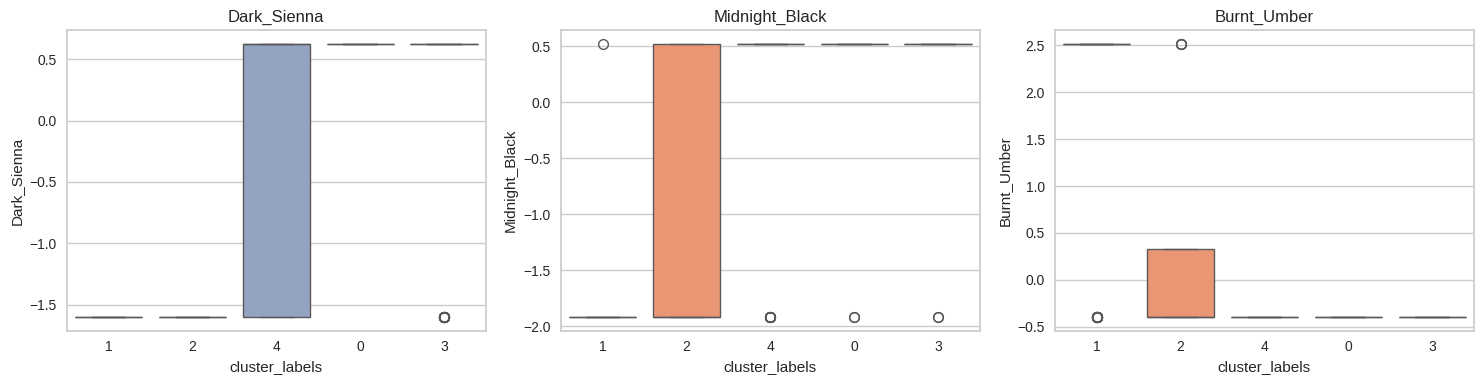

In [30]:
# Boxplots of the key substitution colors per cluster
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(sub_colors):
    sns.boxplot(data=df_normalized, x='cluster_labels', y=col, palette='Set2', ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

The boxplots show the substitution clearly. Cluster 1 (69 paintings) is high on Burnt Umber and low on both Dark Sienna and Midnight Black. Clusters 0, 3, and 4 are the opposite - high on Dark Sienna and Midnight Black, low on Burnt Umber. Cluster 2 (12 paintings) is a small outlier group with mixed values across all three. The clustering picked up the same palette split as the seasonal analysis.

## 5. Findings

**Finding 1: Burnt Umber and Dark Sienna are substitutes.** The correlation matrix flags it, the seasonal plot confirms it, and clustering separates them into different groups.

**Finding 2: It's a time thing, not a per-painting choice.** Burnt Umber goes from ~85% usage to zero around season 7. Dark Sienna and Midnight Black take over at the same time. Within a single era or cluster, the exclusion disappears because Ross was just using one palette or the other. Looks like he swapped palettes at some point rather than choosing between them each painting.

**Finding 3: Dark Sienna and Midnight Black always come together.** High co-occurrence across the board. When Ross started using Dark Sienna, Midnight Black came with it. They cluster together in every group.

**Finding 4: Both methods agree.** Association rules and clustering came at this from completely different angles and landed on the same answer. That makes me more confident it's a real pattern.

## Appendix: AI Tool Usage

Throughout the development of this project, I used AI tools to assist with ideation, structure, and technical implementation.

**1. OpenAI ChatGPT**
ChatGPT was used primarily as a brainstorming and organizational partner. Specific applications included:
* **Ideation & Strategy:** Generating initial ideas for analysis when hitting creative roadblocks.
* **Structure & Writing:** Assisting with the outlining of the report and refining and improving the flow of my writing.
* **Interpretation:** Helping to synthesize findings and offering different perspectives on how to interpret the data results.

Link: https://chatgpt.com/share/698a2ed3-14ac-8002-abe5-e8290c0e38d4

**2. Google Gemini (Integrated in Google Colab)**
Gemini was used as a technical tutor and coding assistant. Specific applications included (I don't think I am able to share any of these queries or chats):
* **Complex Coding:** Generating and debugging complex Python code blocks, particularly for data visualization and association rule mining. I relied heavily on Gemini to conceptualize and code the exclusion analysis (negative associations), as I initially had no idea where to start or how to technically implement rules for item substitutability.
* **Troubleshooting:** Identifying errors in syntax and logic when code execution failed.
* **Skill Acquisition:** Explaining specific coding functions and formatting techniques. For example, I learned how to use Python f-string formatting (e.g., `<20s` for alignment and `.1%` for percentage precision) to create cleaner, more readable output tables.

*Note: All AI-generated suggestions, code, and text were reviewed, tested, and validated